<a href="https://colab.research.google.com/github/Cesare-Caputo/Tote/blob/main/TFRS_SM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 85 kB 1.7 MB/s 
     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 10.6 MB 65 kB/s 


In [ ]:
#!pip install tensorflowjs
#%tensorflow_version 2.x

In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
# imports
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image, display

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Content-Based/dataframes/"


Mounted at /content/gdrive


In [ ]:
import json
from bson.json_util import dumps
#from pymongo import MongoClient

In [ ]:
#Gallery for Visualization
from IPython.display import HTML, Image

def _src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'

def gallery(images, row_height='auto'):
    """Shows a set of images in a gallery that flexes with the width of the notebook.

    Parameters
    ----------
    images: list of str or bytes
        URLs or bytes of images to display

    row_height: str
        CSS height value to assign to all images. Set to 'auto' by default to show images
        with their native dimensions. Set to a value like '250px' to make all rows
        in the gallery equal height.
    """
    figures = []
    for image in images:
        if isinstance(image, bytes):
            src = _src_from_data(image)
            caption = ''
        else:
            src = image
            caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {row_height}">
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')





#Import tagged items from Mongo DB

In [ ]:
# list them as individual dictionaries to access info later
full_items = []
items = []
item_ids= []
for line in open(root_dir + 'taggedItems.json', 'r'):
    data = json.loads(line)
    for item in range(len(data)):
        items.append(data[item])
        full_items.append(data[item])
        item_ids.append(data[item]['_id']['$oid'])


# list untagged items too to find them as individual dictionaries to access info later
untagged_items = []
for line in open(root_dir + 'NottaggedItems.json', 'r'):
    data = json.loads(line)
    for item in range(len(data)):
        full_items.append(data[item])
        untagged_items.append(data[item]['_id']['$oid'])

In [ ]:
# Define find_item() function
def find_item(id):
 return next(item for item in full_items if item["_id"]["$oid"] == id)
# return list of unique items , useful for debuggin mostly
def unpack_unique_reccs(idx):
  s = []
  for i in range(len(idx)):
    s.append(idx[i])
  return list(set(s))

# function to flaten nested list of tags to input into DF
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt



def list_of_tags_from_df(df):
  all_tags_nested_list = []
  for c in df.columns:
    all_tags_nested_list.append(unpack_unique_reccs(df[c].value_counts().index))
  all_tags_list = flatten(all_tags_nested_list)
  return all_tags_list

In [ ]:
interactions_dataset_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE
0,5eb6d78a737d8c0017edc801,5e92133978f479914f162ad8,1.589150e+12,WISH
1,5eb6d78a737d8c0017edc801,5e92133878f479914f1629d9,1.589150e+12,WISH
2,5eb6d78a737d8c0017edc801,5e92154f78f479914f169b93,1.589150e+12,WISH
3,5eb6d78a737d8c0017edc801,5e92135378f479914f163b80,1.589150e+12,WISH
4,5eb6d78a737d8c0017edc801,5e92133878f479914f162a3a,1.589150e+12,WISH


In [ ]:
full_item_df = pd.read_csv(root_dir + 'full_item_df.csv') # tags and description
item_tag_df = pd.read_csv(root_dir + 'item_tag_df.csv') # string tags
user_id_interaction_df = pd.read_csv(root_dir + 'user_id_interaction_df.csv') # user id index based interaction df
full_item_df.set_index(['item'], inplace = True)
item_tag_df.set_index(['item'], inplace = True)
user_id_interaction_df.set_index(['user_id'], inplace = True)

In [ ]:
item_tag_df.head()

,category,primaryColor,primaryPattern,primaryTheme,rawMaterial,article,length,frontOpening,waistRiseLevels,neckline,sleeveLength,armHole,roundNecklineSubsection,sleeveType,cuff,secondaryColor,hemFinish,buttonClosureSubsection,hemline,backNeckline,closedSubsection,halter,strapWidth,squareNecklineSubsection,fullnessSkirt,hood,scoopNecklineSubsection,vNeckSubsection,sweetheartNecklineSubsection,tiedClosureSubsection,subArticle,locationOfTheme,pockets,patchPocketSubsection,collar,traditionalMenswearCollarSubsection,secondaryPattern,thirdColor,customerFacing,hardware,zipperClosureSubsection,closureZippersSubsection,weltPocketSubsection,closureButtonsSubsection,foldOverCollarSubsection,fabrics,highNecklineSubsection,standCollarSubsection,knitSubsection,openSubsection,lining,fourthColor,buttCoverage,legCoverage,rayonSubsection
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5f29685f65f956545839cf5f,tops,beige,stripes,NaN,linen,t-shirts,regular,NaN,NaN,round neckline,short sleeve,drop shoulder,round,plain sleeve,NaN,black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839d227,bottoms,dark gray,solid,NaN,cotton,pants,mid-thigh length,button closure,natural waist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turned up,placket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839cfe6,tops,coral,solid,conversational,cotton,t-shirts,regular,NaN,NaN,round neckline,short sleeve,set-in,crew,plain sleeve,NaN,NaN,NaN,NaN,straight,closed,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839d059,tops,light blue,solid,NaN,cotton,t-shirts,regular,NaN,NaN,round neckline,sleeveless,set-in,round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no halter,wide straps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839d09a,tops,black,stripes,NaN,cotton,t-shirts,regular,NaN,NaN,square neckline,sleeveless,set-in,NaN,NaN,NaN,dark gray,NaN,NaN,tie,NaN,NaN,no halter,wide straps,square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
untagged_item_tag_df = pd.DataFrame(index = untagged_items , columns = list(item_tag_df.columns))
untagged_item_tag_df.index.name = 'item'
untagged_item_tag_df.head()

,category,primaryColor,primaryPattern,primaryTheme,rawMaterial,article,length,frontOpening,waistRiseLevels,neckline,sleeveLength,armHole,roundNecklineSubsection,sleeveType,cuff,secondaryColor,hemFinish,buttonClosureSubsection,hemline,backNeckline,closedSubsection,halter,strapWidth,squareNecklineSubsection,fullnessSkirt,hood,scoopNecklineSubsection,vNeckSubsection,sweetheartNecklineSubsection,tiedClosureSubsection,subArticle,locationOfTheme,pockets,patchPocketSubsection,collar,traditionalMenswearCollarSubsection,secondaryPattern,thirdColor,customerFacing,hardware,zipperClosureSubsection,closureZippersSubsection,weltPocketSubsection,closureButtonsSubsection,foldOverCollarSubsection,fabrics,highNecklineSubsection,standCollarSubsection,knitSubsection,openSubsection,lining,fourthColor,buttCoverage,legCoverage,rayonSubsection
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60ac190268efbb12cc7a7a05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839ced6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839ceef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839cf2d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5f29685f65f956545839cf6e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
full_tax_df = pd.concat([item_tag_df, untagged_item_tag_df])
t_items = full_tax_df.reset_index()
t_items.head()

,item,category,primaryColor,primaryPattern,primaryTheme,rawMaterial,article,length,frontOpening,waistRiseLevels,neckline,sleeveLength,armHole,roundNecklineSubsection,sleeveType,cuff,secondaryColor,hemFinish,buttonClosureSubsection,hemline,backNeckline,closedSubsection,halter,strapWidth,squareNecklineSubsection,fullnessSkirt,hood,scoopNecklineSubsection,vNeckSubsection,sweetheartNecklineSubsection,tiedClosureSubsection,subArticle,locationOfTheme,pockets,patchPocketSubsection,collar,traditionalMenswearCollarSubsection,secondaryPattern,thirdColor,customerFacing,hardware,zipperClosureSubsection,closureZippersSubsection,weltPocketSubsection,closureButtonsSubsection,foldOverCollarSubsection,fabrics,highNecklineSubsection,standCollarSubsection,knitSubsection,openSubsection,lining,fourthColor,buttCoverage,legCoverage,rayonSubsection
0,5f29685f65f956545839cf5f,tops,beige,stripes,NaN,linen,t-shirts,regular,NaN,NaN,round neckline,short sleeve,drop shoulder,round,plain sleeve,NaN,black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f29685f65f956545839d227,bottoms,dark gray,solid,NaN,cotton,pants,mid-thigh length,button closure,natural waist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turned up,placket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f29685f65f956545839cfe6,tops,coral,solid,conversational,cotton,t-shirts,regular,NaN,NaN,round neckline,short sleeve,set-in,crew,plain sleeve,NaN,NaN,NaN,NaN,straight,closed,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f29685f65f956545839d059,tops,light blue,solid,NaN,cotton,t-shirts,regular,NaN,NaN,round neckline,sleeveless,set-in,round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no halter,wide straps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f29685f65f956545839d09a,tops,black,stripes,NaN,cotton,t-shirts,regular,NaN,NaN,square neckline,sleeveless,set-in,NaN,NaN,NaN,dark gray,NaN,NaN,tie,NaN,NaN,no halter,wide straps,square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#t_items.astype('str')
t_items

,item,category,primaryColor,primaryPattern,primaryTheme,rawMaterial,article,length,frontOpening,waistRiseLevels,neckline,sleeveLength,armHole,roundNecklineSubsection,sleeveType,cuff,secondaryColor,hemFinish,buttonClosureSubsection,hemline,backNeckline,closedSubsection,halter,strapWidth,squareNecklineSubsection,fullnessSkirt,hood,scoopNecklineSubsection,vNeckSubsection,sweetheartNecklineSubsection,tiedClosureSubsection,subArticle,locationOfTheme,pockets,patchPocketSubsection,collar,traditionalMenswearCollarSubsection,secondaryPattern,thirdColor,customerFacing,hardware,zipperClosureSubsection,closureZippersSubsection,weltPocketSubsection,closureButtonsSubsection,foldOverCollarSubsection,fabrics,highNecklineSubsection,standCollarSubsection,knitSubsection,openSubsection,lining,fourthColor,buttCoverage,legCoverage,rayonSubsection
0,5f29685f65f956545839cf5f,tops,beige,stripes,NaN,linen,t-shirts,regular,NaN,NaN,round neckline,short sleeve,drop shoulder,round,plain sleeve,NaN,black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f29685f65f956545839d227,bottoms,dark gray,solid,NaN,cotton,pants,mid-thigh length,button closure,natural waist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turned up,placket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f29685f65f956545839cfe6,tops,coral,solid,conversational,cotton,t-shirts,regular,NaN,NaN,round neckline,short sleeve,set-in,crew,plain sleeve,NaN,NaN,NaN,NaN,straight,closed,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f29685f65f956545839d059,tops,light blue,solid,NaN,cotton,t-shirts,regular,NaN,NaN,round neckline,sleeveless,set-in,round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no halter,wide straps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f29685f65f956545839d09a,tops,black,stripes,NaN,cotton,t-shirts,regular,NaN,NaN,square neckline,sleeveless,set-in,NaN,NaN,NaN,dark gray,NaN,NaN,tie,NaN,NaN,no halter,wide straps,square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9441,6028885954a7af2cf4323a2f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9442,6028885954a7af2cf4323a2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9443,6028885954a7af2cf4323a35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9444,6028885954a7af2cf4323a37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ratings_df = user_id_interaction_df.reset_index()
ratings_df.rename(columns={'action': 'rating', 'createdAt':'timestamp'}, inplace = True)
ratings_df.head()

,user_id,item,timestamp,rating
0,60d4c275de93100017f054b4,5f29685f65f956545839d09a,1625380016029,1.0
1,60d4c275de93100017f054b4,5f33000efc074a35b09eeadb,1625380020007,1.0
2,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626584513216,1.0
3,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626584958680,-1.0
4,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626585090459,2.0


# Format inputs to be compatible with TFRS

In [ ]:
items_df = t_items
tote = ratings_df.merge(items_df, on = 'item')

In [ ]:
tote.head()

,user_id,item,timestamp,rating,category,primaryColor,primaryPattern,primaryTheme,rawMaterial,article,length,frontOpening,waistRiseLevels,neckline,sleeveLength,armHole,roundNecklineSubsection,sleeveType,cuff,secondaryColor,hemFinish,buttonClosureSubsection,hemline,backNeckline,closedSubsection,halter,strapWidth,squareNecklineSubsection,fullnessSkirt,hood,scoopNecklineSubsection,vNeckSubsection,sweetheartNecklineSubsection,tiedClosureSubsection,subArticle,locationOfTheme,pockets,patchPocketSubsection,collar,traditionalMenswearCollarSubsection,secondaryPattern,thirdColor,customerFacing,hardware,zipperClosureSubsection,closureZippersSubsection,weltPocketSubsection,closureButtonsSubsection,foldOverCollarSubsection,fabrics,highNecklineSubsection,standCollarSubsection,knitSubsection,openSubsection,lining,fourthColor,buttCoverage,legCoverage,rayonSubsection
0,60d4c275de93100017f054b4,5f29685f65f956545839d09a,1625380016029,1.0,tops,black,stripes,NaN,cotton,t-shirts,regular,NaN,NaN,square neckline,sleeveless,set-in,NaN,NaN,NaN,dark gray,NaN,NaN,tie,NaN,NaN,no halter,wide straps,square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60d4c275de93100017f054b4,5f33000efc074a35b09eeadb,1625380020007,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626584513216,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626584958680,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60d4c275de93100017f054b4,60ac190268efbb12cc7a7a05,1626585090459,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for item in tote.item:
  if item in item_tag_df.index.values:
    print("nice")

nice


In [ ]:
# NOW WE BUILD MODEL USING ALSO TIMESTAMP AND DESCRIPTION
# Everything is converted to tensors and relevant embeddings


### here we create a reference table of the user , item, and quantity purchased
interactions_dict = ratings_df.groupby(['user_id',
                                       'item',
                                       'timestamp',
                                       ])[ 'rating'].mean().reset_index()


## we tansform the table inta a dictionary , which then we feed into tensor slices
# this step is crucial as this will be the type of data fed into the embedding layers
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)


In [ ]:
## #repeat for items

items_dict = t_items.to_dict('list')
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

In [ ]:
items

<MapDataset shapes: {item: (), category: (), primaryColor: ()}, types: {item: tf.string, category: tf.string, primaryColor: tf.string}>

In [ ]:
interactions_dict

In [ ]:
ratings = interactions.map(lambda x: {
    'item' : x['item'],
    'user_id' : x['user_id'],
     'rating' : x['rating'],
})

In [ ]:
### test simplified short embeddings first ######
items = items.map(lambda x: {
    'item' : x['item'],
    'category' : x['category'],
     'primaryColor' : x['primaryColor'],
})

In [ ]:
items_dict =t_items.groupby(['item', 'category', 'primaryColor', 'primaryPattern', 'primaryTheme',
       'rawMaterial', 'article', 'length', 'frontOpening', 'waistRiseLevels',
       'neckline', 'sleeveLength', 'armHole', 'roundNecklineSubsection',
       'sleeveType', 'cuff', 'secondaryColor', 'hemFinish',
       'buttonClosureSubsection', 'hemline', 'backNeckline',
       'closedSubsection', 'halter', 'strapWidth', 'squareNecklineSubsection',
       'fullnessSkirt', 'hood', 'scoopNecklineSubsection', 'vNeckSubsection',
       'sweetheartNecklineSubsection', 'tiedClosureSubsection', 'subArticle',
       'locationOfTheme', 'pockets', 'patchPocketSubsection', 'collar',
       'traditionalMenswearCollarSubsection', 'secondaryPattern', 'thirdColor',
       'customerFacing', 'hardware', 'zipperClosureSubsection',
       'closureZippersSubsection', 'weltPocketSubsection',
       'closureButtonsSubsection', 'foldOverCollarSubsection', 'fabrics',
       'highNecklineSubsection', 'standCollarSubsection', 'knitSubsection',
       'openSubsection', 'lining', 'fourthColor', 'buttCoverage',
       'legCoverage', 'rayonSubsection'])

In [ ]:
users = interactions.map(lambda x: str(x['user_id']))
titles = interactions.map(lambda x: str(x['item'])) ### aka interacted items
categories = items.map(lambda x: str(x['category']))
pcolors = items.map(lambda x: str(x['primaryColor']))
#article = interactions.map(lambda x: str(x['article']))
#length = interactions.map(lambda x: str(x['length']))
#waistRiseLevels = interactions.map(lambda x: str(x['waistRiseLevels']))

In [ ]:
# standardizing timestamp buckets into 1000 evenly spaced ones to save computation
timestamps = np.concatenate(list(interactions.map(lambda x: x["timestamp"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace( min_timestamp, max_timestamp, num=1000,)

In [ ]:
# figure out unique items and user and attribute classes
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000).map(lambda x: x["item"]))))
unique_product_category = np.unique(np.concatenate(list(items.batch(1_000).map(lambda x: x["category"]))))
unique_product_pcolor = np.unique(np.concatenate(list(items.batch(1_000).map(lambda x: x["primaryColor"]))))
#unique_article_category = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["article"]))))
#unique_length_category = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["length"]))))
#unique_waistRiseLevels_category = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["waistRiseLevels"]))))

In [ ]:
print(unique_user_ids)

In [ ]:
# sanity checks on categories extracted
print(len(unique_user_ids))
print(len(unique_item_titles))
print(unique_product_category)
print(unique_product_pcolor)

# Automatically build vocab for each feature

In [ ]:
 ### use only simplified for now #####
feature_names = ['item','category', 'primaryColor']

vocabularies = {}

for feature_name in feature_names:
  #print(feature_name)
  vocab = items.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))


In [ ]:
len(vocabularies['item'])
len(vocabularies['timestamp'])

In [ ]:
 ### use only simplified for now #####
 ####DO NOT RUN THIS #####
feature_names = ['item','category', 'primaryColor', 'primaryPattern', 'primaryTheme',
       'rawMaterial', 'article', 'length', 'frontOpening', 'waistRiseLevels',
       'neckline', 'sleeveLength', 'armHole', 'roundNecklineSubsection',
       'sleeveType', 'cuff', 'secondaryColor', 'hemFinish',
       'buttonClosureSubsection', 'hemline', 'backNeckline',
       'closedSubsection', 'halter', 'strapWidth', 'squareNecklineSubsection',
       'fullnessSkirt', 'hood', 'scoopNecklineSubsection', 'vNeckSubsection',
       'sweetheartNecklineSubsection', 'tiedClosureSubsection', 'subArticle',
       'locationOfTheme', 'pockets', 'patchPocketSubsection', 'collar',
       'traditionalMenswearCollarSubsection', 'secondaryPattern', 'thirdColor',
       'customerFacing', 'hardware', 'zipperClosureSubsection',
       'closureZippersSubsection', 'weltPocketSubsection',
       'closureButtonsSubsection', 'foldOverCollarSubsection', 'fabrics',
       'highNecklineSubsection', 'standCollarSubsection', 'knitSubsection',
       'openSubsection', 'lining', 'fourthColor', 'buttCoverage',
       'legCoverage', 'rayonSubsection']

vocabularies = {}

for feature_name in feature_names:
  print(feature_name)
  #items = items.map(lambda x: { feature_name: x[feature_name],})
  #vocab = items.batch(1_000_000).map(lambda x: x[feature_name])
  #vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))


In [ ]:
items

<TensorSliceDataset shapes: {item: (), category: (), primaryColor: (), primaryPattern: (), primaryTheme: (), rawMaterial: (), article: (), length: (), frontOpening: (), waistRiseLevels: (), neckline: (), sleeveLength: (), armHole: (), roundNecklineSubsection: (), sleeveType: (), cuff: (), secondaryColor: (), hemFinish: (), buttonClosureSubsection: (), hemline: (), backNeckline: (), closedSubsection: (), halter: (), strapWidth: (), squareNecklineSubsection: (), fullnessSkirt: (), hood: (), scoopNecklineSubsection: (), vNeckSubsection: (), sweetheartNecklineSubsection: (), tiedClosureSubsection: (), subArticle: (), locationOfTheme: (), pockets: (), patchPocketSubsection: (), collar: (), traditionalMenswearCollarSubsection: (), secondaryPattern: (), thirdColor: (), customerFacing: (), hardware: (), zipperClosureSubsection: (), closureZippersSubsection: (), weltPocketSubsection: (), closureButtonsSubsection: (), foldOverCollarSubsection: (), fabrics: (), highNecklineSubsection: (), standCo

#Define initial model structure

In [ ]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding_dimension = 32
        max_tokens = 10_000

        ## user id
        self.user_embedding = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(
                                                    vocabulary=unique_user_ids, mask_token=None),
                                                    tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),])


        #timestamp
        self.timestamp_embedding = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
                                    tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),])
        self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization(axis = None)
        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
                          self.user_embedding(inputs["user_id"]),
                          self.timestamp_embedding(inputs["timestamp"]),
                          tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
                      ], axis=1)

In [ ]:
### getting this just to run for now but need to include age etc on here ####
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()
        #self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                        #kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [ ]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.embedding_dimension = 32

        max_tokens = 10_000
        str_features = ['item','category', 'primaryColor']
        self._all_features = str_features
        self._embeddings = {}

        # Compute embeddings for string features.
        for feature_name in str_features:
          vocabulary = vocabularies[feature_name]
          self._embeddings[feature_name] = tf.keras.Sequential(
              [tf.keras.layers.experimental.preprocessing.StringLookup(
                  vocabulary=vocabulary, mask_token=None),
              tf.keras.layers.Embedding(len(vocabulary) + 1,
                                        self.embedding_dimension)
        ])


    def call(self, features):
          # Concatenate embeddings
          embeddings = []
          for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

          x = tf.concat(embeddings, axis=1)
          return x

  ### candidate model
class CandidateModel(tf.keras.Model):
    """Model for encoding items."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding items.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = ItemModel()

         # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)


In [ ]:
class ToteSimple2(tfrs.models.Model):
    def __init__(self):
      super().__init__()
      # self.query_model =  UserModel()
      self.query_model = tf.keras.Sequential([
          UserModel(),
          tf.keras.layers.Dense(32)
      ], name = 'query_name')

      self.candidate_model = tf.keras.Sequential([
          ItemModel(),
          tf.keras.layers.Dense(32)
      ])

      self.task = tfrs.tasks.Retrieval(
          metrics = tfrs.metrics.FactorizedTopK(
              # candidates = items.batch(128).map(self.candidate_model),
              candidates = items.batch(128).map(self.candidate_model),
          )
      )

    def compute_loss(self, features, training = False):
          query_embeddings = self.query_model({
              "user_id": features["user_id"],
              "timestamp": features["timestamp"],
              })

          item_embeddings = self.candidate_model({"item": features["item"],
                                                  "category" : features["category"],
                                                  "primaryColor" : features["primaryColor"]})

          return self.task(query_embeddings, item_embeddings)

In [ ]:
cached_train

In [ ]:
num_epochs = 30

model = ToteSimple2()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

# Define simple deep model, fit and evaluate

In [ ]:
# cross netowkr relu dnn model

class ToteSimpleDeepModel(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)

        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=items.batch(128).map(self.candidate_model),
        ),
    )

    def compute_loss(self, features,  training=False):

        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        #ratings = features.pop("user_rating")
        #user_embeddings, item_embeddings, rating_predictions = self(features)
        #ratings = features.pop("user_rating")

        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
            })

            # We compute the loss for each task.
        #retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

        item_embeddings = self.candidate_model({"item": features["item"],
                                                "category" : features["category"],
                                                "primaryColor" : features["primaryColor"]})

        #retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)

        return self.task(
        query_embeddings, item_embeddings, compute_metrics=not training)

In [ ]:
model

In [ ]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32


# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train_n = np.int(.8*len(shuffled))
test_n = np.int(.2* len(shuffled))

train = shuffled.take(train_n)
test = shuffled.skip(train_n).take(test_n)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()


In [ ]:
num_epochs = 30

model = ToteSimpleDeepModel([32])

In [ ]:
model.query_model([32])

In [ ]:
num_epochs = 30

model = ToteSimpleDeepModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

In [ ]:
# cross netowkr relu dnn model

class CrossDNNModel(tfrs.models.Model):
    def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float, projection_dim=None ):
        super().__init__()
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)

                # item models.
        self.item_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_item_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
        ])

        ## user model
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])


                ## this is Relu-Based DNN
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        ## rating and retrieval task.
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

        self.retrieval_task : tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model)))

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight


    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])

        # And pick out the item features and pass them into the item model.
        item_embeddings = self.item_model(features["product_id"])

        return (
            user_embeddings,
            item_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and item embeddings.
            self.rating_model(
                tf.concat([user_embeddings, item_embeddings], axis=1)
            ),
        )



    def compute_loss(self, features, training=False):

        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        ratings = features.pop("user_rating")
        user_embeddings, item_embeddings, rating_predictions = self(features)

        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "product_id": features["product_id"],
            "timestamp": features["timestamp"],
            "category": features["category"],
            "article": features["article"],
            "length": features["length"],
            "waistRiseLevels": features["waistRiseLevels"],
            })

            # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        #retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

        item_embeddings = self.candidate_model(features["product_id"])
        retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)
        rating_loss = 0.01

         # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

In [ ]:
userid_model = CrossDNNModel([32], rating_weight=0.5, retrieval_weight=0.5,
                      projection_dim=None)
userid_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
one_layer_history = userid_model.fit(cached_train, validation_data=cached_train,
        validation_freq=5, epochs=50)

Epoch 1/50


KeyError: ignored

In [ ]:
metrics = userid_model.evaluate(cached_test, return_dict=True)
print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Retrieval top-5 accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
print(f"Retrieval top-1 accuracy: {metrics['factorized_top_k/top_1_categorical_accuracy']:.3f}.")

1/1 [==============================] - 0s 199ms/step - root_mean_squared_error: 0.5562 - factorized_top_k/top_1_categorical_accuracy: 0.6556 - factorized_top_k/top_5_categorical_accuracy: 0.6556 - factorized_top_k/top_10_categorical_accuracy: 0.6556 - factorized_top_k/top_50_categorical_accuracy: 0.6556 - factorized_top_k/top_100_categorical_accuracy: 0.6556 - loss: 1059.5035 - regularization_loss: 0.0000e+00 - total_loss: 1059.5035
Retrieval top-100 accuracy: 0.656.
Retrieval top-50 accuracy: 0.656.
Retrieval top-10 accuracy: 0.656.
Retrieval top-5 accuracy: 0.656.
Retrieval top-1 accuracy: 0.656.


# Define Cross Netwrok DNN model

# Fitting and evaluating

In [ ]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32


# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train_n = np.int(.8*len(shuffled))
test_n = np.int(.2* len(shuffled))

train = shuffled.take(train_n)
test = shuffled.skip(train_n).take(test_n)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model = SimpleCrossDNNModel([32], rating_weight=0.01, retrieval_weight=0.99,
                      projection_dim=None)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
two_layer_history = model.fit(cached_train, validation_data=cached_test,
        validation_freq=5, epochs=50)

In [ ]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

NameError: ignored

# Og DCNN

# Evaluate Brute force vs Scann ranking

Start with combined

In [ ]:
# instantiate SCANN model
scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann.index(interactions.batch(1024).map(model.candidate_model), interactions.batch(1024).map(lambda x: x['product_id']))
for row in interactions.batch(1).take(1):
    print(f"Best SCANN recommendations: {scann(row)[1].numpy()[:, :3].tolist()}")


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['user_id', 'user_rating', 'product_id', 'category', 'timestamp', 'article', 'length', 'waistRiseLevels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
Consider rewriting this model with the Functional API.


Best SCANN recommendations: [[b'5e92185278f479914f171998', b'5e92188b78f479914f173de0', b'5e92188b78f479914f173e5d']]


In [ ]:
# instantiate SCANN model
#scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
#scann.index(items.batch(1024).map(model.candidate_model), identifiers=items)
#for row in interactions.batch(1).take(1):
    #print(f"Best SCANN recommendations: {scann(row)[1].numpy()[:, :3].tolist()}")


Best SCANN recommendations: [[b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)']]


In [ ]:
# instantiate SCANN model
# uses only training set to be more consitent
scann1 = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann1.index(train.batch(1024).map(model.candidate_model), train.batch(1024).map(lambda x: x['product_id']))
for row in interactions.batch(1).take(1):
    print(f"Best SCANN recommendations: {scann1(row)[1].numpy()[:, :3].tolist()}")


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['user_id', 'user_rating', 'product_id', 'category', 'timestamp', 'article', 'length', 'waistRiseLevels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
Consider rewriting this model with the Functional API.


Best SCANN recommendations: [[b'5e92133978f479914f162ad8', b'5e921f8a78f479914f18ff42', b'5e92135a78f479914f163fd2']]


In [ ]:
# This defined version based on user model so only user id is input
user_scann = tfrs.layers.factorized_top_k.ScaNN(userid_model.user_model , num_reordering_candidates=1000)
user_scann.index(items.batch(1024).map(userid_model.candidate_model), identifiers=items)
for row in interactions.batch(1).take(1):
    print(f"Best SCANN recommendations: {user_scann(row)[1].numpy()[:, :3].tolist()}")

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Best SCANN recommendations: [[b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)']]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['user_id', 'user_rating', 'product_id', 'category', 'timestamp', 'article', 'length', 'waistRiseLevels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [ ]:
# This defined version based on user model so only user id is input
user_scann2 = tfrs.layers.factorized_top_k.ScaNN(userid_model.user_model , num_reordering_candidates=1000)
user_scann2.index(train.batch(1024).map(model.candidate_model), train.batch(1024).map(lambda x: x['product_id']))
for row in interactions.batch(1).take(1):
    print(f"Best SCANN recommendations: {user_scann2(row)[1].numpy()[:, :3].tolist()}")

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['user_id', 'user_rating', 'product_id', 'category', 'timestamp', 'article', 'length', 'waistRiseLevels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Best SCANN recommendations: [[b'5e92184a78f479914f1714a6', b'5e921d0f78f479914f1821f9', b'5e92136078f479914f164359']]


SCANN retrieves prettyu much the same but musch faster, better to proceed there

# Exporting to KERAs for TF JS deployment

In [ ]:
# this shows how this retrieves top reccomendations based on user id

user1 = b'5efe5a6746e7a90017257050'
user2 = b'5ebb281fc880800017471b94'
# Need to call it to set the shapes.
# so right now this seems to be only working with user model, fine for deployment but needs to be fixed to accept all queries
_ , reccs = user_scann2(tf.constant(["user2"]))
print(f"Top recommendations for user2: {reccs[0][:3]}")
_ , reccs = user_scann2(tf.constant([user1]))
print(f"Top recommendations for user1: {reccs[0][:3]}")

Top recommendations for user2: [b'5e92133978f479914f162ad8' b'5e921f8a78f479914f18ff42'
 b'5e92135a78f479914f163fd2']
Top recommendations for user1: [b'5e92155d78f479914f16a751' b'5e92133978f479914f162ad8'
 b'5e921f8a78f479914f18ff42']


In [ ]:
# trying new query format to test reccomendations
master_df = master_df.rename(columns = { 'TIMESTAMP': 'timestamp'})
test_query = dict(master_df[['user_id',
                            'product_id',
                            'timestamp',
                            'category' ,
                            'article', 'length', 'waistRiseLevels'
                            ]].iloc[3].map(lambda x:tf.expand_dims(x, axis = 0)))

In [ ]:
test_query2 = dict(master_df[['user_id',
                            'product_id',
                            'timestamp',
                            'category' ,
                            'article', 'length', 'waistRiseLevels'
                            ]].iloc[100].map(lambda x:tf.expand_dims(x, axis = 0)))

In [ ]:
# this is proper way to formulate test query
# shows how to get reccomendations based on both user id and queries that are relevant to taxonomy DIRECTLY
_ , reccs = scann(test_query2, 100)
print(f"Top recommendations for user2: {reccs[0][:50]}")

Top recommendations for user2: [b'5e92185278f479914f171998' b'5e92188b78f479914f173de0'
 b'5e92188b78f479914f173e5d' b'5e92195078f479914f1756e8'
 b'5e92196578f479914f1766c2' b'5e92196978f479914f1769d6'
 b'5e92197278f479914f17710b' b'5e92197478f479914f17728a'
 b'5e921b9e78f479914f17cdf4' b'5e921ba078f479914f17d088'
 b'5e921bb478f479914f17df41' b'5e921e0a78f479914f186f08'
 b'5e921e0a78f479914f186f08' b'5e921e1678f479914f1878b6'
 b'5e921e1e78f479914f187e2f' b'5e921e2678f479914f1884dd'
 b'5e921ede78f479914f18bbb9' b'5e921f8778f479914f18fc96'
 b'5e921f8878f479914f18fd4c' b'5e92134778f479914f163393'
 b'5e92134f78f479914f1638fc' b'5e92135078f479914f163925'
 b'5e92136e78f479914f164ebc' b'5e92136e78f479914f164ebc'
 b'5e92137278f479914f16515d' b'5e92137278f479914f16515d'
 b'5e92137678f479914f165461' b'5e92137678f479914f165461'
 b'5e92154878f479914f1695e1' b'5e92154f78f479914f169b87'
 b'5e92155078f479914f169cd6' b'5e92157278f479914f16b671'
 b'5e92133678f479914f162927' b'5e92133978f479914f162ad8'


In [ ]:
_ , reccs = scann(test_query2)
print(f"Top recommendations for user2: {reccs[0][:10]}")

Top recommendations for user2: [b'5e92185278f479914f171998' b'5e92188b78f479914f173de0'
 b'5e92188b78f479914f173e5d' b'5e92195078f479914f1756e8'
 b'5e92196578f479914f1766c2' b'5e92196978f479914f1769d6'
 b'5e92197278f479914f17710b' b'5e92197478f479914f17728a'
 b'5e921b9e78f479914f17cdf4' b'5e921ba078f479914f17d088']


In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:
_  = scann1(test_query)
path = os.path.join(root_dir, "model_scann_query_v1_new")
scann1.save(
path,
options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"]) ,
                                  save_format='tf'
)
loaded = tf.keras.models.load_model(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Content-Based/model_scann_query_v1_new/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Content-Based/model_scann_query_v1_new/assets


ValueError: ignored

In [ ]:
# attempting export of user scann model
_ , reccs = user_scann2(tf.constant([user1]))
path = os.path.join(root_dir, "model_user_scann_v1")
user_scann2.save(
path,
options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"]) ,
                                  save_format='tf'
)
loaded = tf.keras.models.load_model(path)

In [ ]:
loaded

In [ ]:
# this is proper way to formulate test query
# shows how to get reccomendations based on both user id and queries that are relevant to taxonomy DIRECTLY
_ , reccs = scann(test_query, 100)
print(f"Top recommendations for user2: {reccs[0][:99]}")

In [ ]:
path = root_dir + 'path_to_my_model'
user_scann2.save(path, save_format = "tf")

In [ ]:
scann.save_weights('path_to_my_weights', save_format='tf')

In [ ]:
loaded

In [ ]:
loaded = tf.keras.models.load_model(path)

In [ ]:
loaded

In [ ]:
path

'/content/gdrive/My Drive/Content-Based/model_scann_query_v5_functional'

In [ ]:
# check that loaded model producing same reccomendations as original
# it does, lets go ahead and export it
_ , reccs = loaded(test_query)
print(f"Top recommendations: {reccs[0][:3]}")

In [ ]:
# check that loaded model producing same reccomendations as original
# it does, lets go ahead and export it
_ , reccs = loaded(tf.constant(["user1"]))
print(f"Top recommendations: {reccs[0][:3]}")

In [ ]:
tf

<module 'tensorflow' from '/usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py'>

In [ ]:
pip install tensorflowjs

In [ ]:
import tensorflowjs

In [ ]:
tensorflowjs.converters.save_keras_model(model, MODEL_DIR)

In [ ]:
# Save the model
MODEL_DIR = './js_model'
tensorflowjs.converters.save_keras_model(model, MODEL_DIR )

In [ ]:
loaded

In [ ]:
!tensorflowjs_converter --input_format=keras {path} ./

# Set up simple non cutom model to see if it exports

In [ ]:
rank_df.head()

In [ ]:
item_tag_df.head()

In [ ]:
rank_df['rating'] = rank_df['user_rating'].astype(int)

In [ ]:
ratings_df = rank_df
books_df = item_tag_df

In [ ]:
#ratings_df.drop(columns = "TIMESTAMP" , inplace=True)
ratings_df.drop(columns = "user_rating" , inplace=True)

In [ ]:
# super hack try as substituing for indexes
ratings_df['user_id1'] = list(range(len(ratings_df['user_id'])))
ratings_df['product_id1'] = list(range(len(ratings_df['user_id'])))

In [ ]:
ratings_df.drop(columns = "user_id" , inplace=True)
ratings_df.drop(columns = "product_id" , inplace=True)

In [ ]:
print(ratings_df.shape)
print(ratings_df.user_id1.nunique())
print(ratings_df.product_id1.nunique())
ratings_df.isna().sum()

(2411, 3)
2411
2411


rating         0
user_id1       0
product_id1    0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (1928, 3)
Shape of test data: (483, 3)


In [ ]:
import tensorflow.keras as tf

In [ ]:
# create simple nn and run  matrix factorization

#Get the number of unique entities in books and users columns
nbook_id = ratings_df.product_id1.nunique()
nuser_id = ratings_df.user_id1.nunique()


#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)

model = tf.Model([input_books, input_users], x_out)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_861 (Embedding)       (None, 1, 15)        36180       input_19[0][0]                   
__________________________________________________________________________________________________
embedding_862 (Embedding)       (None, 1, 15)        36180       input_20[0][0]                   
____________________________________________________________________________________________

In [ ]:
hist = model.fit([Xtrain.product_id1, Xtrain.user_id1], Xtrain.rating,
                 batch_size=64,
                 epochs=5,
                 verbose=1,
                 validation_data=([Xtest.product_id1, Xtest.user_id1], Xtest.rating))

Epoch 1/5
31/31 [==============================] - 1s 9ms/step - loss: 0.1902 - val_loss: 0.1594
Epoch 2/5
31/31 [==============================] - 0s 3ms/step - loss: 0.1594 - val_loss: 0.1640
Epoch 3/5
31/31 [==============================] - 0s 3ms/step - loss: 0.1046 - val_loss: 0.1936
Epoch 4/5
31/31 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.2535
Epoch 5/5
31/31 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.2177


In [ ]:

hist.history

{'loss': [0.1901763677597046,
  0.15944528579711914,
  0.10457112640142441,
  0.014959501102566719,
  0.0024223648943006992],
 'val_loss': [0.15941385924816132,
  0.1639614999294281,
  0.1936476081609726,
  0.25352194905281067,
  0.2177429348230362]}

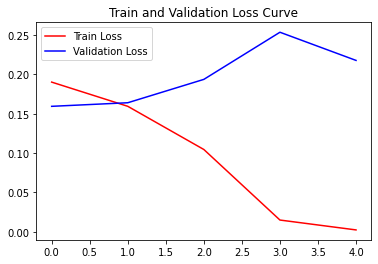

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.savefig("loss.png")
plt.show()

In [ ]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
model

NameError: ignored

In [ ]:
files

NameError: ignored

In [ ]:
dir

<function dir>

# Connect to AWS and deploy

In [ ]:
# Imports
! pip install boto3
import boto3
import json
import numpy as np
import pandas as pd
import time

In [ ]:
object_url = https://tote-test-recc-model.s3.amazonaws.com/aws_models.zip

SyntaxError: ignored

In [ ]:
npm init

SyntaxError: ignored

In [ ]:
# deploy on lambda

# Prepare Data to build ranking model

note do not suffer same efficiency issues so can use much denser network. This model takes item and user ids and returns predicted ranking.

In [ ]:
rank_df = interactions_dataset_df.replace(to_replace="WISH" , value =1)
rank_df = rank_df.replace(to_replace="DISLIKE" , value =0)
rank_df = rank_df.rename(columns={'EVENT_TYPE': 'user_rating'})
rank_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,user_rating
0,5eb6d78a737d8c0017edc801,5e92133978f479914f162ad8,1.589150e+12,1
1,5eb6d78a737d8c0017edc801,5e92133878f479914f1629d9,1.589150e+12,1
2,5eb6d78a737d8c0017edc801,5e92154f78f479914f169b93,1.589150e+12,1
3,5eb6d78a737d8c0017edc801,5e92135378f479914f163b80,1.589150e+12,1
4,5eb6d78a737d8c0017edc801,5e92133878f479914f162a3a,1.589150e+12,1


In [ ]:
# Create dictionary to access items in DF while mantaining user id
c_r = rank_df.reset_index()
ratings_dict_rank = c_r.to_dict('list')
# convert to TF data objects
interaction_dataset_rank = tf.data.Dataset.from_tensor_slices(ratings_dict_rank)

In [ ]:
# HERE WE REOBTAIN RATINGS TF DATA OBJECT INCLUDING PREDICTIONS
ratings_rank = interaction_dataset_rank.map(lambda x: {
    "ITEM_ID": x["ITEM_ID"],
    "USER_ID": x["USER_ID"],
    "user_rating": x["user_rating"],
})



In [ ]:
# Here we do 80-20 train test split
tf.random.set_seed(42)
shuffled = ratings_rank.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

len(shuffled)
train_n = np.int(.8*len(shuffled))
test_n = np.int(.2* len(shuffled))

train_rank = shuffled.take(train_n)
test_rank = shuffled.skip(train_n).take(test_n)



In [ ]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.item_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_item_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    user_id, item_id= inputs

    user_embedding = self.user_embeddings(user_id)
    item_embedding = self.item_embeddings(item_id)

    return self.ratings(tf.concat([user_embedding, item_embedding], axis=1))

In [ ]:
task_rank = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Instantiate and train model with ranking

In [ ]:
# base version of the sameincluding ranking
class ToteOldTaxModelRank(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    rating_predictions = self.ranking_model((features["USER_ID"], features["ITEM_ID"]))

    # The task computes the loss and the metrics.
    return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [ ]:
#instantiate version of model
model_rank = ToteOldTaxModelRank()
model_rank.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
cached_train_rank = train_rank.shuffle(100_000).batch(8192).cache()
cached_test_rank = test_rank.batch(4096).cache()

In [ ]:
# train model
model_rank.fit(cached_train_rank, epochs=3)

Epoch 1/3
1/1 [==============================] - 1s 1s/step - root_mean_squared_error: 0.4603 - loss: 0.2119 - regularization_loss: 0.0000e+00 - total_loss: 0.2119
Epoch 2/3
1/1 [==============================] - 0s 17ms/step - root_mean_squared_error: 0.4153 - loss: 0.1725 - regularization_loss: 0.0000e+00 - total_loss: 0.1725
Epoch 3/3
1/1 [==============================] - 0s 21ms/step - root_mean_squared_error: 0.4142 - loss: 0.1715 - regularization_loss: 0.0000e+00 - total_loss: 0.1715


In [ ]:
# now check ability of model to assess
model_rank.evaluate(cached_test_rank, return_dict=True)

1/1 [==============================] - 0s 222ms/step - root_mean_squared_error: 0.3979 - loss: 0.1583 - regularization_loss: 0.0000e+00 - total_loss: 0.1583


{'loss': 0.15831612050533295,
 'regularization_loss': 0,
 'root_mean_squared_error': 0.3978895843029022,
 'total_loss': 0.15831612050533295}

# Comvine ranking and Retrieval into single model

In [ ]:
# start with query tower, determine dimensions of candidate and query representation
embedding_dimension = 32

In [ ]:
user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [ ]:
# do same for item model
item_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_item_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
])

However, we now have 2 tasks instead of a single one like before. First is to predict ratings, second to retrieve the best reccomendations

In [ ]:
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [ ]:
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=items.batch(128)
    )
)

NOW we put everything together in a single model class

In [ ]:
class ToteJointModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and item models.
    self.item_model : tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_item_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_user_ids, mask_token=None),
      # We add an additional embedding to account for unknown tokens.
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user anditem embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=items.batch(128).map(self.item_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["USER_ID"])
    # And pick out the item ID and pass them into the movie model.
    item_embeddings = self.item_model(features["ITEM_ID"])

    return (
        user_embeddings,
        item_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, item_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, item_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

start by assessing model only focused on ranking

In [ ]:
cached_train_rank = train_rank.shuffle(100_000).batch(8192).cache()
cached_test_rank = test_rank.batch(4096).cache()

In [ ]:
model = ToteJointModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
model.fit(cached_train_rank, epochs=3)
metrics = model.evaluate(cached_test_rank, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1/1 [==============================] - 2s 2s/step - root_mean_squared_error: 0.4755 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0073 - factorized_top_k/top_10_categorical_accuracy: 0.0135 - factorized_top_k/top_50_categorical_accuracy: 0.0794 - factorized_top_k/top_100_categorical_accuracy: 0.1810 - loss: 0.2261 - regularization_loss: 0.0000e+00 - total_loss: 0.2261
Epoch 2/3
1/1 [==============================] - 0s 226ms/step - root_mean_squared_error: 0.4170 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0062 - factorized_top_k/top_10_categorical_accuracy: 0.0135 - factorized_top_k/top_50_categorical_accuracy: 0.0794 - factorized_top_k/top_100_categorical_accuracy: 0.1836 - loss: 0.1739 - regularization_loss: 0.0000e+00 

#COMPARE WITH solution only focused on retrieval- in our case seems to improve performance of both

In [ ]:
model = ToteJointModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train_rank, epochs=3)
metrics = model.evaluate(cached_test_rank, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
1/1 [==============================] - 1s 1s/step - root_mean_squared_error: 0.4696 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.1867e-04 - factorized_top_k/top_10_categorical_accuracy: 5.1867e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0218 - factorized_top_k/top_100_categorical_accuracy: 0.1048 - loss: 14583.8369 - regularization_loss: 0.0000e+00 - total_loss: 14583.8369
Epoch 2/3
1/1 [==============================] - 0s 239ms/step - root_mean_squared_error: 0.4718 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0062 - factorized_top_k/top_10_categorical_accuracy: 0.0233 - factorized_top_k/top_50_categorical_accuracy: 0.1955 - factorized_top_k/top_100_categorical_accuracy: 0.4274 - loss: 14546.0107 - regularization_loss: 0.0000e+00 - total_loss: 14546.0107
Epoch 3/3
1/1 [==============================] - 0s 444ms/step - root_mean_squared_error:

#TRY VERSION WITH EQUAL WEIGHTS TO BOTH TASKS. Performance improves on retrieval but similar for ranking

In [ ]:
model = ToteJointModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train_rank, epochs=3)
metrics = model.evaluate(cached_test_rank, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
1/1 [==============================] - 1s 1s/step - root_mean_squared_error: 0.4791 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0010 - factorized_top_k/top_50_categorical_accuracy: 0.0441 - factorized_top_k/top_100_categorical_accuracy: 0.1255 - loss: 14583.8369 - regularization_loss: 0.0000e+00 - total_loss: 14583.8369
Epoch 2/3
1/1 [==============================] - 0s 244ms/step - root_mean_squared_error: 0.4230 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0119 - factorized_top_k/top_50_categorical_accuracy: 0.2194 - factorized_top_k/top_100_categorical_accuracy: 0.4658 - loss: 14544.8408 - regularization_loss: 0.0000e+00 - total_loss: 14544.8408
Epoch 3/3
1/1 [==============================] - 0s 453ms/step - root_mean_squared_error: 0.4

Acess some reccomendations using SCANN

In [ ]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index(items.batch(100).map(model.item_model), items)

In [ ]:
_, reccomended_ids = scann_index(tf.constant(["42"]))
print(reccomended_ids)

tf.Tensor(
[[b'5e92185a78f479914f171e81' b'5e92195578f479914f175996'
  b'5e92196178f479914f176382' b'5e921d0f78f479914f1821f9'
  b'5e92195e78f479914f176100' b'5e92195c78f479914f175f6e'
  b'5e921b9578f479914f17c6e2' b'5e921d1b78f479914f182bb1'
  b'5e921d2378f479914f183181' b'5e921df078f479914f185e0e']], shape=(1, 10), dtype=string)


In [ ]:
_, reccomended_ids = scann_index(tf.constant(["200"]))
print(reccomended_ids)

tf.Tensor(
[[b'5e92185a78f479914f171e81' b'5e92195578f479914f175996'
  b'5e92196178f479914f176382' b'5e921d0f78f479914f1821f9'
  b'5e92195e78f479914f176100' b'5e92195c78f479914f175f6e'
  b'5e921b9578f479914f17c6e2' b'5e921d1b78f479914f182bb1'
  b'5e921d2378f479914f183181' b'5e921df078f479914f185e0e']], shape=(1, 10), dtype=string)


In [ ]:
def gallery_top_n_reccs_SCANN_model(user_index, n_reccs, model):
    scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
    scann_index.index(items.batch(100).map(model.item_model), items)
    _, reccomended_ids = scann_index(tf.constant(["user_index"]))
    image_urls = []
    for i in range(n_reccs):
      item_id_n = reccomended_ids[0][i].numpy().decode()
      item = find_item(item_id_n)
      image_urls.append(item['header_img'])

    return gallery(image_urls, '200px')

In [ ]:
gallery_top_n_reccs_SCANN_model(100,10 , model)

In [ ]:
gallery_top_n_reccs_SCANN(42,10)

# Build alternative version of model including feature embeddings


we are gonna start with rank dataframe and interaction dataset rank from above since user ratings already converted




In [ ]:
rank_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,user_rating
0,5eb6d78a737d8c0017edc801,5e92133978f479914f162ad8,1.589150e+12,1
1,5eb6d78a737d8c0017edc801,5e92133878f479914f1629d9,1.589150e+12,1
2,5eb6d78a737d8c0017edc801,5e92154f78f479914f169b93,1.589150e+12,1
3,5eb6d78a737d8c0017edc801,5e92135378f479914f163b80,1.589150e+12,1
4,5eb6d78a737d8c0017edc801,5e92133878f479914f162a3a,1.589150e+12,1


In [ ]:
rank_df = interactions_dataset_df.replace(to_replace="WISH" , value =1)
rank_df = rank_df.replace(to_replace="DISLIKE" , value =0)
rank_df = rank_df.rename(columns={'EVENT_TYPE': 'user_rating'})
rank_df.head(0)

In [ ]:
ratings_plus = interaction_dataset_rank.map(lambda x: {
    "ITEM_ID": x["ITEM_ID"],
    "USER_ID": x["USER_ID"],
    "user_rating": x["user_rating"],
    "timestamp" : x["TIMESTAMP"]
})



In [ ]:
for x in ratings_plus.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'ITEM_ID': b'5e92133978f479914f162ad8',
 'USER_ID': b'5eb6d78a737d8c0017edc801',
 'timestamp': 1589150000000.0,
 'user_rating': 1}


In [ ]:
# lets define vocabulary and way to acess as did from first principes above
item_id_lookup = tf.keras.layers.experimental.preprocessing.StringLookup()
item_id_lookup.adapt(ratings_plus.map(lambda x: x["ITEM_ID"]))

In [ ]:
item_id_lookup.vocabulary_size()

488

In fact, the StringLookup layer allows us to configure multiple OOV indices. If we do that, any raw value that is not in the vocabulary will be deterministically hashed to one of the OOV indices. The more such indices we have, the less likley it is that two different raw feature values will hash to the same OOV index. Consequently, if we have enough such indices the model should be able to train about as well as a model with an explicit vocabulary without the disdvantage of having to maintain the token list.

We can take this to its logical extreme and rely entirely on feature hashing, with no vocabulary at all. This is implemented in the tf.keras.layers.experimental.preprocessing.Hashing layer.

In [ ]:
# We set up a large number of bins to reduce the chance of hash collisions.
# we do not proceed with hashing in this case
num_hashing_bins = 200_000

item_id_hashing = tf.keras.layers.experimental.preprocessing.Hashing(
    num_bins=num_hashing_bins
)

When creating the embedding layer for movie titles, we are going to set the first value to the size of our title vocabulary (or the number of hashing bins). The second is up to us: the larger it is, the higher the capacity of the model, but the slower it is to fit and serve.

**NOTE THAT NOT COMPLETELY SURE EMBEDDING NEEDED SINCE ITEMS ALREADYHAVE UNIQUE IDS, BUT FOLLOWING FORMAT OF TEMPLATE FOR NOW**

In [ ]:
item_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=item_id_lookup.vocabulary_size(),
    output_dim=32
)

In [ ]:
item_id_model = tf.keras.Sequential([item_id_lookup, item_id_embedding])

In [ ]:
# REPEAT THE SAME FOR USER IDS
user_id_lookup = tf.keras.layers.experimental.preprocessing.StringLookup()
user_id_lookup.adapt(ratings_plus.map(lambda x: x["USER_ID"]))

user_id_embedding = tf.keras.layers.Embedding(user_id_lookup.vocabulary_size(), 32)

user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])

# Normalize continous features

In [ ]:
# timesteamp normaliztion
timestamp_normalization = tf.keras.layers.experimental.preprocessing.Normalization()
timestamp_normalization.adapt(ratings_plus.map(lambda x: x["timestamp"]).batch(1024))

for x in ratings_plus.take(10).as_numpy_iterator():
  print(f"Normalized timestamp: {timestamp_normalization(x['timestamp'])}.")


Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0530659]].
Normalized timestamp: [[-1.0473512]].
Normalized timestamp: [[-1.0473512]].


Proceed with discretization instead since no reason to suspect this feature(timestamp) has continous effect. Use max and min values as below to then form embeddings

In [ ]:
# discretize and bucketize timestampos
max_timestamp = ratings_plus.map(lambda x: np.int(x["timestamp"])).reduce(
    tf.cast(0, tf.int32), tf.maximum).numpy().max()
min_timestamp = ratings_plus.map(lambda x: np.int(x["timestamp"])).reduce(
    np.int32(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [-2.14748365e+09 -2.14533401e+09 -2.14318438e+09]


Given the bucket boundaries we can transform timestamps into embedding

In [ ]:
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])

for timestamp in ratings_plus.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():
  print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")

Timestamp embedding: [[-0.04622876  0.02517148 -0.0248639   0.01240172  0.02884286 -0.04648713
  -0.01091643 -0.0013787  -0.03732798  0.0061652  -0.02928642  0.01482738
  -0.01785966  0.00902931 -0.00846255 -0.04645826  0.02176611 -0.0388688
  -0.00015344 -0.03232596 -0.03802253  0.00434472  0.03981825 -0.01177793
   0.03463825 -0.02811283 -0.04282252 -0.03663028 -0.02288889  0.00028872
   0.00138374 -0.02032625]].


# Add description as vectorized test to tokenize in items data

In [ ]:
# find corresponding descriptions and include in DF in same order as items introduced
description_list = []
for i in items_dataset_df["ITEM_ID"]:
  id = i
  description_list.append( description_by_item[id])

items_dataset_df["description"] = description_list

In [ ]:
items_dataset_df.head()

,ITEM_ID,OCCASION,PATTERN,MATERIAL,LOCATION,IMAGE,COLOR,STYLE,TEXT,FIT,SEASON,SLEEVE_LENGHT,OPENING,LENGHT,CUFF,WAISTLINE,BODY_LENGHT,COLLAR,POCKET,SILHOUETTE,LAPEL,SLEEVE_TYPE,HEM_TYPE,NECKLINE,WAIST_LEVEL,FULLNESS,description
0,5e92133378f479914f162671,None,None,Cotton,Montreal,None,Gray,Basic,None,Loose,Fall,None,None,None,None,None,None,None,None,None,None,None,Banded,Round,None,None,BASICS
1,5e92133978f479914f162a9d,None,None,Cotton,Montreal,None,Purple,Basic,None,Regular,Summer,Short Sleeve,None,None,None,None,None,None,None,None,None,Set-in Sleeve,Straigth,Round,None,None,"BASICS,DIVIDED"
2,5e92133478f479914f1627b5,None,None,Cotton,Montreal,Logo,Pink,Basic,None,Regular,Summer,Short Sleeve,None,None,None,None,None,None,None,None,None,Set-in Sleeve,Straigth,Round,None,None,DIVIDED
3,5e92133478f479914f162791,None,None,Denim,Other,None,Black,Casual,None,Regular,Fall,None,Button,None,Plain,None,Hip Length,None,None,None,None,None,Straigth,None,None,None,L.O.G.G.
4,5e92133678f479914f162927,Workout,None,Cotton,Montreal,None,Black,Active wear,None,Regular,Spring,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BASICS


In [ ]:
for x in items_dataset.take(2).as_numpy_iterator():
  pprint.pprint(x)

In [ ]:
desc_text.get_vocabulary()[1:7]

['[UNK]', 'divided', 'fashion', 'hm', 'logg', 'everyday']

To finish the processing, we now need to embed the text. Because each title contains multiple words, we will get multiple embeddings for each title. For use in a donwstream model these are usually compressed into a single embedding. Models like RNNs or Transformers are useful here, but averaging all the words' embeddings together is a good starting point